# Background and motivation
As we all know, it is always difficult to find good datasets for image analysis, even more so when the data of interest is difficult to collect. In the field of space robotics, firsthand data is very scarce and seldom freely accessible. To the knowledge of the authors, there exists no labelled dataset of planetary landscape images that could be used for any kind of machine learning approach to object detection or segmentation. Our goal is to openly provide a decent substitute for anyone who wishes to use such an approach on a lunar environment without manual labelling.

# First Look at the Data
Below is a side-by-side view of the first image of the dataset (render0001.tif) and its corresponding segmented ground truth (ground0001.tif).

![Render and its ground truth segmentation](https://i.imgur.com/m5ja0BI.png)

From this, we can make a number of observations that should be kept in mind when using this dataset, in decreasing order of importance:
* **3 **(technically 4)** classes are considered: large rocks (in blue), smaller rocks (in green), the sky (in red)** (and everything else, in black)
* **The segmented ground truth is not perfect**. In particular, there are some instances (like above) where a small rock is embedded in a larger rock. We recommend all users of the dataset to be aware of this when using the segmentation data, and we provide cleaned-up images of the segmentation under the images/clean folder. For users wishing to clean up images differently also show an example of how to morphologically close holes inside large rocks, apply thresholds and removes smaller rocks in the code snips below.
* **The camera used is noise-free, and no data augmentation is performed**. It is up to the user to decide on what data augmentation pipeline they see fit to use, though we recommend that particular attention be paid to **adding sensor noise to renders, especially if the goal is to perform validation test on real lunar images**. An example of such sensor effect augmentation can be found here: https://github.com/alexacarlson/SensorEffectAugmentation.
* **Only rocks measuring more than 10cm are usually represented on the segmented image**. This is to avoid cluttering and focus on rocks that are relevant to detect;
* **Colors go darker for distant rocks**. This is also to keep focus on relevant rocks, which are usually closest to the observer. However, the user is free to set their own threshold to determine whether or not a certain rock should be considered depending on its color intensity (cf. the blue rock). As can be seen from the images below, giving a minimum intensity threshold betweeen 50 and 200 is recommended to avoid noise from distant rocks.
* **Bounding boxes are only drawn around blue rocks of intensity above 150 and dimensions above 20x20 pixels**. This is, again, to only consider rocks that are clearly visible while leaving aside those further away. 


# Testing on real lunar pictures
You may have noticed that real lunar pictures are also provided alongside the renders. Those were taken by the Chang'e 3 rover (image credit: CNSA), equipped with two cameras: PCAM and TCAM. Those cameras are quite different and we found it useful to keep their images separate so users can identify how well their segmentation works on each camera. We also hand-drew ground truth segmentation for these  images, arbitrarily selecting blue and green rocks (keep in mind that not all rocks are present in the ground truth when examining results such as false postitives). As an example, we tried using a modified UNet architecture on the dataset and used the trained result on some of Chang'e 3's images. Below are examples of both the potential and the limitations of the dataset. While some rocks are correctly and precisely detected, others (such as rocks with complex shapes, or those partially covered in sands) are not detected at all. We hope that this dataset put in the right hands will lead to even better results.

![Test on real lunar pictures](https://i.imgur.com/7GRUlcS.png)
(from left to right: original picture, ground truth (hand-drawn), segmentation trained with the Artificial Lunar Landscape Dataset.)

Text(0.5, 1.0, 'FIG 1.2 - Filling holes inside larger rocks')

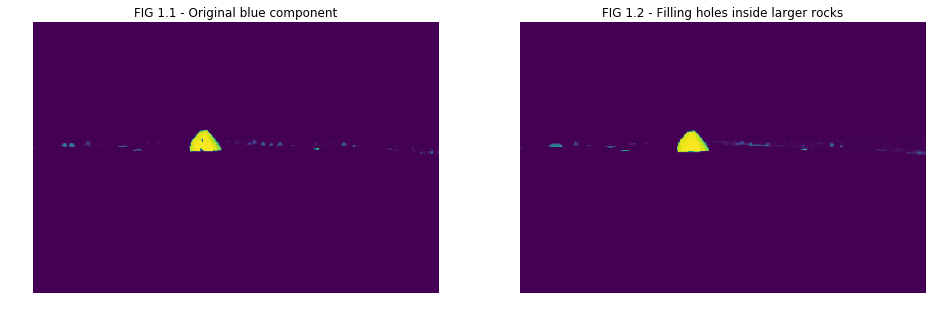

In [1]:
# This code snip fills holes inside large (blue) rocks

import cv2
import  numpy
import matplotlib.pyplot as plt

# Loads a segmented image and isolates larger (blue) rocks
ground_truth = numpy.array(cv2.imread("../input/images/ground/ground0001.png"))
data_blue = ground_truth[:,:,0]

# Creates a 10x10 kernel so as to close any hole smaller than 10x10 pixels inside blue rocks
kernel = numpy.ones((10,10),numpy.uint8)
closing = cv2.morphologyEx(data_blue, cv2.MORPH_CLOSE, kernel)

fig, ax = plt.subplots(1, 2, figsize=(16,9))
ax[0].axis('off')
ax[0].imshow(data_blue)
ax[0].set_title('FIG 1.1 - Original blue component')
ax[1].axis('off')
ax[1].imshow(closing)
ax[1].set_title('FIG 1.2 - Filling holes inside larger rocks')

Text(0.5, 1.0, 'FIG 2.5 - Threshold = 150')

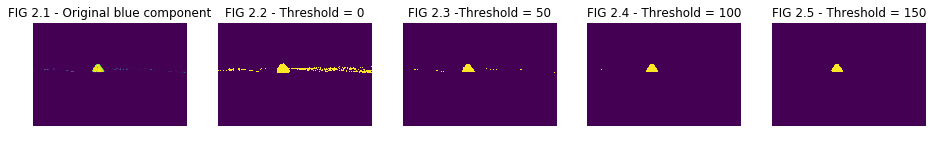

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy

# Loads the segmented image and converts it to an array
ground_truth = Image.open("../input/images/ground/ground0001.png")
data = numpy.array(ground_truth)

# Defines different thresholds deciding which large (blue) rocks to keep
data_blue = data[:,:,2]
min_blue_value_1 = 0
min_blue_value_2 = 50
min_blue_value_3 = 100
min_blue_value_4 = 150

blue_1 = (data_blue > min_blue_value_1)
blue_2 = (data_blue > min_blue_value_2)
blue_3 = (data_blue > min_blue_value_3)
blue_4 = (data_blue > min_blue_value_4)

fig, ax = plt.subplots(1, 5, figsize=(16,9))
ax[0].axis('off')
ax[0].imshow(data_blue)
ax[0].set_title('FIG 2.1 - Original blue component')
ax[1].axis('off')
ax[1].imshow(blue_1)
ax[1].set_title('FIG 2.2 - Threshold = 0')
ax[2].axis('off')
ax[2].imshow(blue_2)
ax[2].set_title('FIG 2.3 -Threshold = 50')
ax[3].axis('off')
ax[3].imshow(blue_3)
ax[3].set_title('FIG 2.4 - Threshold = 100')
ax[4].axis('off')
ax[4].imshow(blue_4)
ax[4].set_title('FIG 2.5 - Threshold = 150')



Text(0.5, 1.0, 'Green component without the smallest rocks')

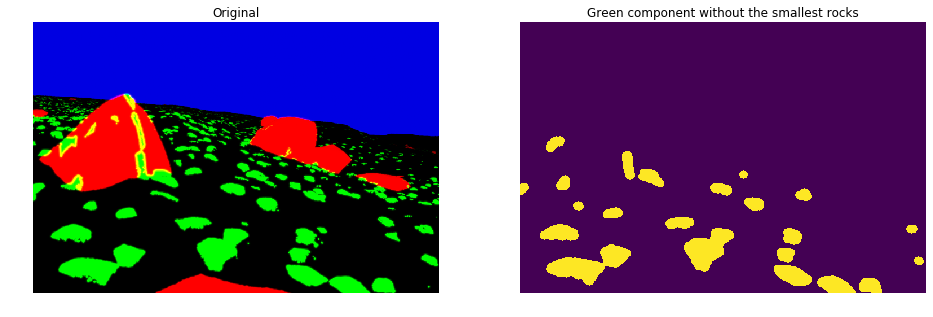

In [3]:
# This code snip only keeps the most relevant green rocks

import cv2
import  numpy
import matplotlib.pyplot as plt
ground_truth = numpy.array(cv2.imread("../input/images/ground/ground0015.png"))
data = numpy.array(ground_truth)

data_green = data[:,:,1]
min_value = 100
h,w = data_green.shape
for y in range(0, h):
    for x in range(0, w):
        data_green[y, x] = 255 if data_green[y, x] >= min_value else 0
        
kernel = numpy.ones((15,15),numpy.uint8)
kernel_circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
opening = cv2.morphologyEx(data_green, cv2.MORPH_OPEN, kernel_circle)
fig, ax = plt.subplots(1, 2, figsize=(16,9))
ax[0].axis('off')
ax[0].imshow(ground_truth)
ax[0].set_title('Original')
ax[1].axis('off')
ax[1].imshow(opening)
ax[1].set_title('Green component without the smallest rocks')

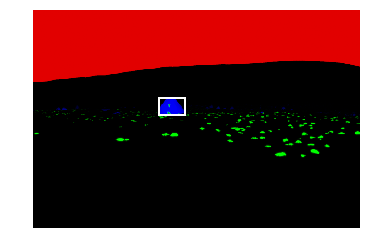

In [4]:
from PIL import Image
import csv
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy

# Loads the bounding boxes file and extracts those from the first frame
bounding_boxes_list = []
with open("../input/bounding_boxes.csv") as bounding_boxes_csv:
    reader = csv.reader(bounding_boxes_csv, delimiter=',')
    next(bounding_boxes_csv) # Skip the header
    for row in reader:
        if row[0] == '1':
            bounding_boxes_list.append(row[1:5])
        else:
            break

# Loads the first segmented image and displays its bounding boxes
ground_truth = numpy.array(Image.open("../input/images/ground/ground0001.png"))
fig,ax = plt.subplots(1)
ax.axis('off')
ax.imshow(ground_truth)
for  bounding_box in bounding_boxes_list:
    bounding_box = list(map(float, bounding_box)) 
    rect = patches.Rectangle((bounding_box[0]-0.5,bounding_box[1]-0.5),bounding_box[2],bounding_box[3],linewidth=2,edgecolor='w',facecolor='none')
    ax.add_patch(rect)
plt.show()

# Technical information
* Render dimensions: 720x480 pixels
* Camera FOV: 65° 
* Camera film aperture: 36x24mm
* Camera focal length: ~20mm
* Camera orientation: Yaw between 0° and 360°; Pitch between -30° and 0° (so as to limit the portion of images occupied by the sky); Roll between -20° and 20°
* Sun elevation: Random, uniform distribution between 20° and 40° for 75% of frames, between 40° and 50° for 25% of frames
* Sun heading: Random, uniform distribution between 0° and 360°
